#### Настройка окружения и конфиг


In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_DIR = "../data/raw"
TRAIN_PATH = os.path.join(DATA_DIR, "train-dset-001.parquet")
TEST_PATH = os.path.join(DATA_DIR, "test-dset-small.parquet")
SAMPLE_PATH = "../data/transformed/train-sample.parquet"

#### Генерация сэмпла


In [ ]:
import duckdb

QUERIES_AMOUNT = 30_000

con = duckdb.connect(database=":memory:")

con.execute(f"""
    CREATE VIEW train AS
    SELECT * FROM parquet_scan('{TRAIN_PATH}')
""")

# 1. Выбираем уникальные query_id
uniq_q = con.execute("SELECT DISTINCT query_id FROM train").fetch_df()

# 2. Сэмплируем query_id (pandas)
uniq_q = uniq_q.sample(n=QUERIES_AMOUNT, random_state=RANDOM_STATE)

# 3. Делаем подвыборку train по этим query_id
qset = tuple(uniq_q["query_id"].tolist())
sample_df = con.execute(f"""
    SELECT *
    FROM train
    WHERE query_id IN {qset}
""").fetch_df()

# 4. Сохраняем сэмпл
os.makedirs(os.path.dirname(SAMPLE_PATH), exist_ok=True)
sample_df.to_parquet(SAMPLE_PATH, index=False)

print("Saved sample:", SAMPLE_PATH, "Shape:", sample_df.shape)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Saved sample: ../data/transformed/train-sample.parquet Shape: (342886, 14)


#### Загрузка сэмпла для EDA


In [3]:
sample_df = pd.read_parquet(SAMPLE_PATH, engine="pyarrow")
test_df = pd.read_parquet(TEST_PATH, engine="pyarrow")

sample_df.head()


,query_id,item_id,query_text,item_title,item_description,query_cat,query_mcat,query_loc,item_cat_id,item_mcat_id,item_loc,price,item_query_click_conv,item_contact
__null_dask_index__,,,,,,,,,,,,,,
460,184,3500509301,покос травы,Покос травы,"Покос травы возле дома, на дачном участке или ...",114.0,1178215.0,633270.0,114,1178215,633270,500.0,0.016,0.0
461,184,7238120547,покос травы,Спил деревьев. Расчистка участков,"Спил деревьев, без повреждения крыш и коммуник...",114.0,1178215.0,633270.0,114,1178215,633270,500.0,0.035,1.0
462,184,2407415937,покос травы,Покос травы тримером,Покос травы любой сложности. Цена зависит от о...,114.0,1178215.0,633270.0,114,1178215,633270,100.0,0.045,0.0
463,184,2481434699,покос травы,Покос травы триммером,"Покос травы бензо тримером. Качественно, быстр...",114.0,1178215.0,633270.0,114,1178215,633270,200.0,0.046,1.0
464,184,7536241781,покос травы,Расчистка дачных участков,"Расчистим участок любой сложности, спилим дере...",114.0,1178215.0,633270.0,114,1178215,633270,100.0,-1.000,0.0


In [ ]:
from ydata_profiling import ProfileReport

ProfileReport(sample_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

##### Базовые проверки

-   Проверка уникальности пар (query_id, item_id).
-   Убедимся, что в тесте нет `item_contact`.
-   Проверим, что нет пропусков в ключевых ID.


In [ ]:
# уникальность пар
dup_cnt = len(sample_df) - len(sample_df[["query_id", "item_id"]].drop_duplicates())
print("Duplicate (query_id,item_id):", dup_cnt)

# пропуски
null_share = (sample_df.isna().mean().sort_values(ascending=False)).round(3)
display(null_share.head(12))

# баланс таргета
pos_rate = sample_df["item_contact"].mean()
print(f"Positive rate: {pos_rate:.4f}")


Duplicate (query_id,item_id): 0


query_mcat          0.225
item_description    0.000
item_title          0.000
item_id             0.000
query_text          0.000
query_id            0.000
query_cat           0.000
query_loc           0.000
item_cat_id         0.000
item_mcat_id        0.000
item_loc            0.000
price               0.000
dtype: float64

Positive rate: 0.0442


#### По запросам: #кандидатов и #позитивов

-   Сколько объявлений на один `query_id`.
-   Сколько позитивов на один `query_id`.


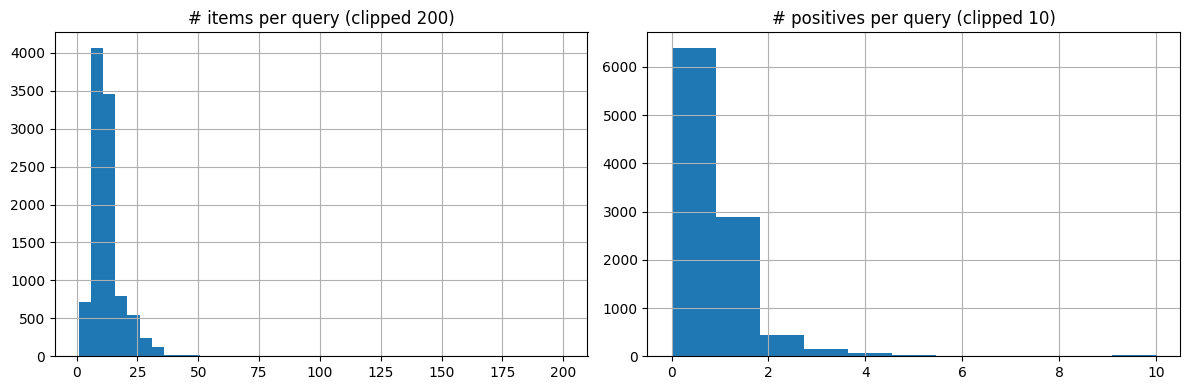

In [ ]:
items_per_q = sample_df.groupby("query_id")["item_id"].size()
pos_per_q = sample_df.groupby("query_id")["item_contact"].sum()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(items_per_q.clip(upper=200), bins=40)
ax[0].set_title("# items per query (clipped 200)")
ax[1].hist(pos_per_q.clip(upper=10), bins=11)
ax[1].set_title("# positives per query (clipped 10)")
plt.tight_layout()
plt.show()


##### Тексты: длины

-   Длины по символам и словам.


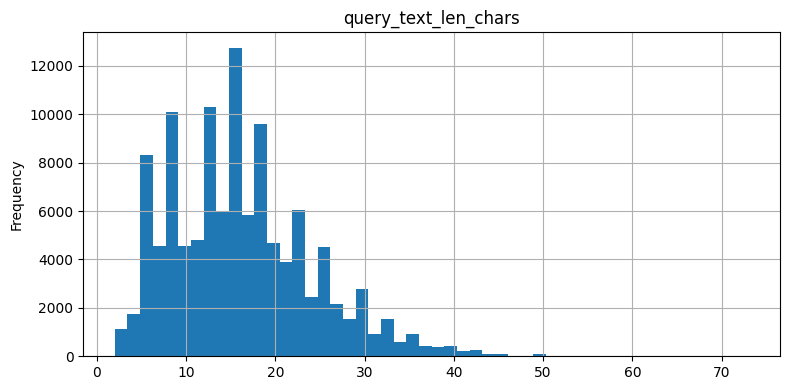

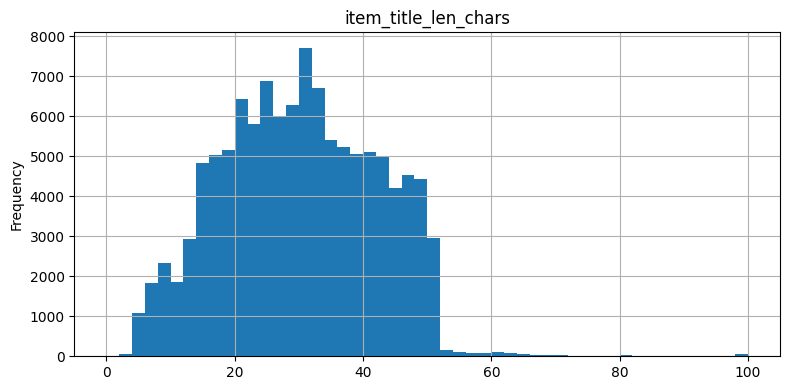

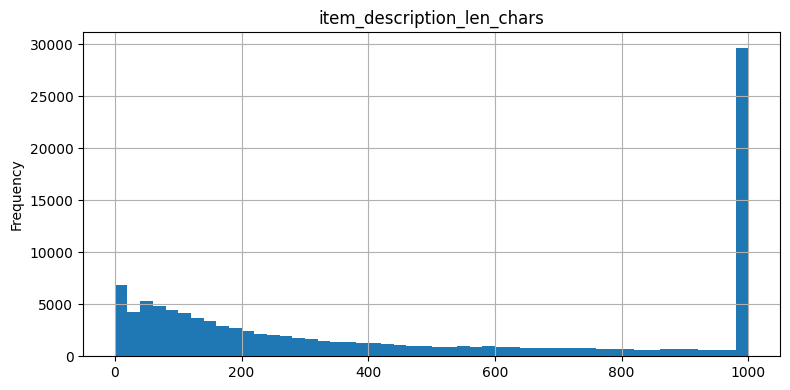

In [ ]:
txt_cols = ["query_text", "item_title", "item_description"]
for c in txt_cols:
    sample_df[c + "_len_chars"] = sample_df[c].fillna("").str.len().astype("int32")
    sample_df[c + "_len_words"] = (
        sample_df[c].fillna("").str.count(r"\S+").astype("int32")
    )


# гистограммы длин
for c in [x for x in sample_df.columns if x.endswith("_len_chars")]:
    sample_df[c].clip(upper=2000).plot(kind="hist", bins=50, title=c)
    plt.tight_layout()
    plt.show()
